### Mean-Variance Frontier with financial data

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns; sns.set()
import pandas_datareader.data as web

data = pd.DataFrame()
for code in ['005930', '000660', '035720', '035420'] : 
    data = pd.concat([data,web.DataReader(code, 'naver', start='2019-01-01', end='2020-01-01')['Close'].apply(int)], axis=1)

data.columns = ['se', 'skh', 'kk','nvr']
noa = len(data.columns)
data.head()

,se,skh,kk,nvr
2019-01-02 00:00:00,38750,60600,20473,118000
2019-01-03 00:00:00,37600,57700,20573,122000
2019-01-04 00:00:00,37450,58300,20774,125500
2019-01-07 00:00:00,38750,58700,20673,131500
2019-01-08 00:00:00,38100,59200,20051,130000


In [2]:
data

,se,skh,kk,nvr
2019-01-02,38750,60600,20473,118000
2019-01-03,37600,57700,20573,122000
2019-01-04,37450,58300,20774,125500
2019-01-07,38750,58700,20673,131500
2019-01-08,38100,59200,20051,130000
...,...,...,...,...
2019-12-23,55500,94600,29806,184000
2019-12-24,55000,93800,29405,182000
2019-12-26,55400,94800,29706,180500
2019-12-27,56500,96000,30810,183500


$\mu_y = 250 * \mu_d$

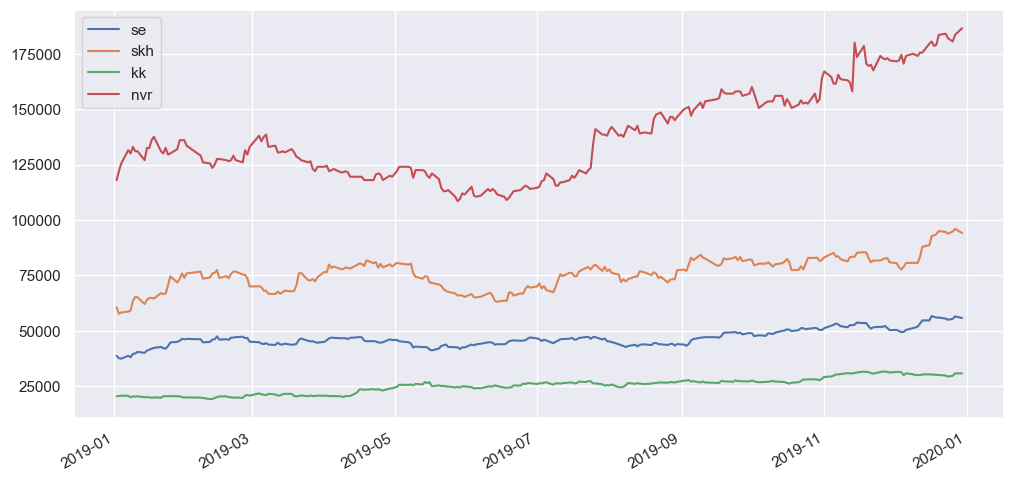

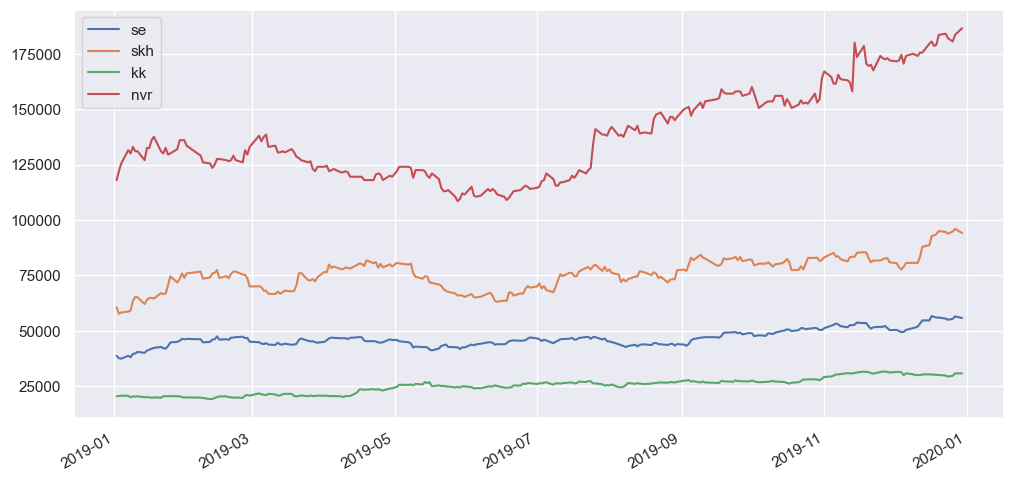

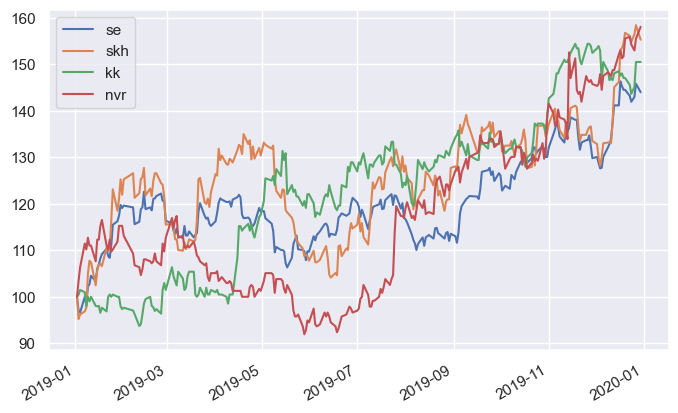

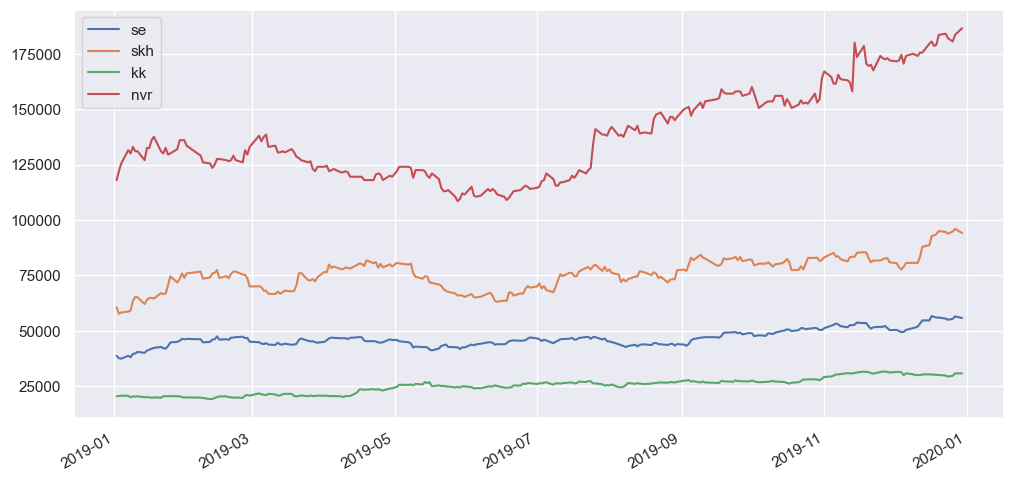

In [6]:
data.plot(figsize=(12,6))
plt.show()

In [5]:
# Normalized Plot
(data / data.iloc[0] * 100).plot(figsize=(8, 5))

<AxesSubplot:>

### Random Portfolio (random weights)

In [4]:
weights = np.random.random(noa)
weights /= sum(weights)

In [5]:
# get returns
ret = data.pct_change().dropna()

# use sample mean and variance as estimates of expected portfolio return and variance
port_mean = np.sum(weights * ret.mean() *250) # sample mean
port_var = np.dot(weights.T, np.dot(ret.cov()*250, weights)) #sample variance
port_std = np.sqrt(port_var) # sample standard deviation


### Now, we simulate $\left( \hat{\mu}, \hat{\sum} \right)$ with various weights

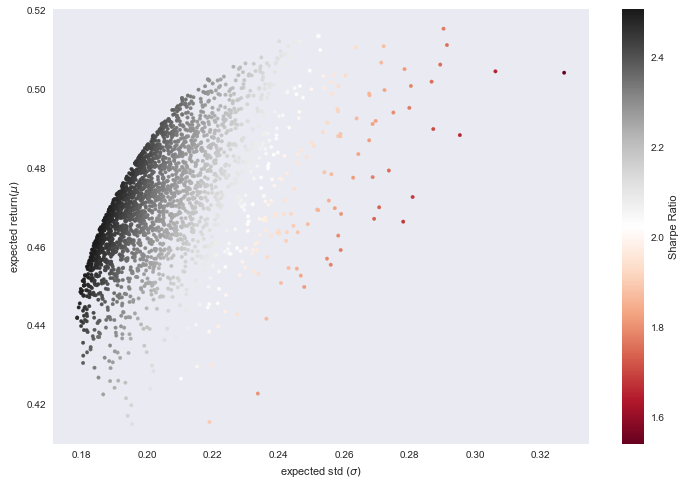

In [6]:
port_rets = []
port_std = []

def ret_std(weight, ret):
    port_mean = np.sum(weight * ret.mean() *250)
    port_var = np.dot(weight.T, np.dot(ret.cov()*250, weight))
    port_std = np.sqrt(port_var)
    return port_mean, port_std

for w in range(2500):
    weight = np.random.random(noa)
    weight /= np.sum(weight)
    mu, sig = ret_std(weight, ret)
#     print(mu, sig)
    port_rets.append(mu)
    port_std.append(sig)

sr = np.array(port_rets)/np.array(port_std)
    
plt.style.use('seaborn')
plt.figure(figsize=(12,8))
plt.scatter(port_std, port_rets, c=sr,marker='.',  cmap='RdGy')
plt.colorbar(label='Sharpe Ratio')
plt.ylabel('expected return$(μ)$')
plt.xlabel('expected std $(σ)$');
plt.grid()

In [7]:
def statistics(weights, rf=0):
    ''' Return portfolio statistics.
    
    Parameters
    ==========
    weights : array-like
        weights for different securities in portfolio
    
    Returns
    =======
    pret : float
        expected portfolio return
    pvol : float
        expected portfolio volatility
    pret / pvol : float
        Sharpe ratio for rf=0
    '''
    weights = np.array(weights)
    pret = np.sum(ret.mean() * weights) * 252 - rf
    pvol = np.sqrt(np.dot(weights.T, np.dot(ret.cov() * 252, weights)))
    return np.array([pret, pvol, pret / pvol])

## Optimization 1: weights maximizing the Sharpe ratio
\begin{align*}
max_{w_i's} (sr)\equiv \frac{r_p-r_f}{\sigma_p} \\
~~& s.t   \sum w_i =1 , 0 \le w_i \le 1
\end{align*}

Let $r$

In [8]:
import scipy.optimize as opt

def min_func_sharpe(weights, rf=0):
    return -statistics(weights, rf)[2]

cons = ({'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})
bnds = tuple((0, 1) for x in range(noa))
noa * [1. / noa,]

opts = opt.minimize(min_func_sharpe, noa * [1. / noa,], method='SLSQP',
                       bounds=bnds, constraints=cons)

opts

     fun: -2.518584891871219
     jac: array([-1.16974115e-04, -3.48091125e-05,  1.03354454e-04,  5.45382500e-05])
 message: 'Optimization terminated successfully.'
    nfev: 39
     nit: 6
    njev: 6
  status: 0
 success: True
       x: array([0.35041199, 0.10066938, 0.2992044 , 0.24971424])

In [9]:
opts.x.round(3)

array([0.35 , 0.101, 0.299, 0.25 ])

In [10]:
statistics(opts['x']).round(3)

array([0.461, 0.183, 2.519])

## Optimization 2: weights minimizing variance (volatility)
\begin{align*}
min_{w_i's} \sigma_p^2 \\
~~& s.t   \sum w_i =1 , 0 \le w_i \le 1
\end{align*}

In [11]:
def min_func_volatility(weights):
    return statistics(weights)[1] **2

cons = ({'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})
bnds = tuple((0, 1) for x in range(noa))
noa * [1. / noa,]

[0.25, 0.25, 0.25, 0.25]

In [12]:
optv = opt.minimize(min_func_volatility, noa * [1. / noa,], method='SLSQP',
                       bounds=bnds, constraints=cons)

In [13]:
optv.x.round(3)

array([0.522, 0.   , 0.288, 0.19 ])

In [14]:
statistics(optv['x']).round(3)

array([0.442, 0.179, 2.473])

## Optimization 3: Optimal Portfolio Frontier
\begin{align*}
min_{w_i's} \sigma_p^2 \\
~~& s.t   \sum w_i =1 , 0 \le w_i \le 1,   r_p = \bar{r}
\end{align*}

In [15]:
def min_func_port(weights):
    return statistics(weights)[1]

cons = ({'type': 'eq', 'fun': lambda x:  statistics(x)[0] - tret},
        {'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})
bnds = tuple((0, 1) for x in weights)

trets = np.linspace(0.0, 0.25, 50)
tvols = []
for tret in trets:
    cons = ({'type': 'eq', 'fun': lambda x:  statistics(x)[0] - tret},
            {'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})
    res = opt.minimize(min_func_port, noa * [1. / noa,], method='SLSQP',
                       bounds=bnds, constraints=cons)
    tvols.append(res['fun'])
tvols = np.array(tvols)

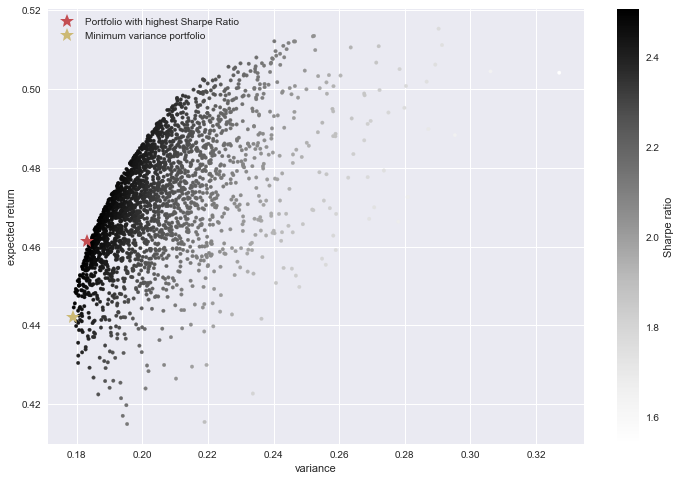

In [16]:
plt.figure(figsize=(12, 8))
plt.scatter(port_std, port_rets,
            c=np.array(port_rets) / np.array(port_std), marker='.')
            # random portfolio composition=
plt.plot(statistics(opts['x'])[1], statistics(opts['x'])[0],
         'r*', markersize=15.0, label = 'Portfolio with highest Sharpe Ratio')
            # portfolio with highest Sharpe ratio
plt.plot(statistics(optv['x'])[1], statistics(optv['x'])[0],
         'y*', markersize=15.0, label = 'Minimum variance portfolio')
            # minimum variance portfolio  
plt.legend()
plt.grid(True)
plt.xlabel('variance')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')

### Efficient Frontier with riskfree asset (CML, CAL)
- Let $r_f = 0.02$

In [17]:
rf = 0.02
slope = (statistics(opts['x'])[0] - rf) / statistics(opts['x'])[1]
var_list = [x*slope + rf for x in np.linspace(0.16,0.30,2500)]

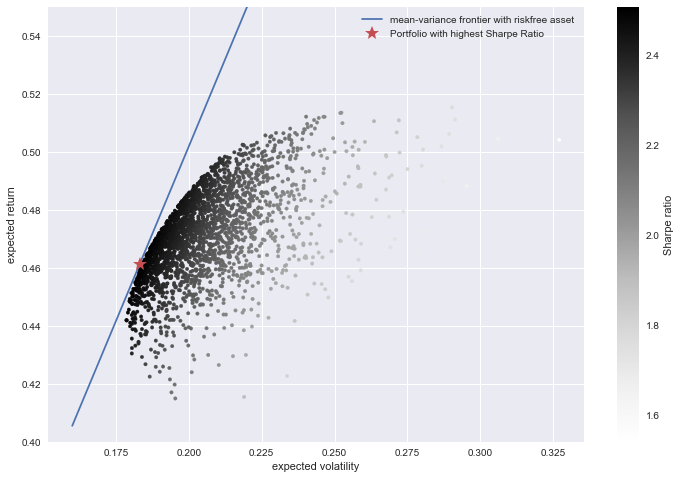

In [18]:
x =  np.linspace(0.16,0.30,2500)
y = var_list

plt.figure(figsize=(12, 8))
plt.scatter(port_std, port_rets,
            c=np.array(port_rets) / np.array(port_std), marker='.')
plt.plot(x,y, label = 'mean-variance frontier with riskfree asset')
            # random portfolio composition  
plt.plot(statistics(opts['x'])[1], statistics(opts['x'])[0],
         'r*', markersize=15.0, label = 'Portfolio with highest Sharpe Ratio')
            # portfolio with highest Sharpe ratio
plt.ylim((0.4, 0.55))
plt.legend()
plt.grid(True)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')                    

## Plots in Slide

In [19]:
df = pd.read_excel('data1.xls', index_col=0, parse_date = True)
df.head(5)

,var1,var2,var3,var4,var5,var6,var7,var8,var9,var10,...,var41,var42,var43,var44,var45,var46,var47,var48,var49,var50
date,,,,,,,,,,,,,,,,,,,,,
1990-01-01,-7.092,-1.773,-5.882000,-7.655000,3.846,-6.335,-10.390,-20.388,-6.329,0.000,...,-7.865,-12.000,-7.865,-14.721,-4.762,-16.204,4.250,-1.351,-10.667,-1.600
1990-02-01,1.878,0.722,4.688000,-4.663000,0.000,7.246,7.246,3.659,0.000,0.204,...,26.829,4.464,26.829,3.571,3.533,3.546,10.843,-0.438,4.806,0.781
1990-03-01,3.817,15.484,1.493000,-3.370000,3.704,8.597,2.649,4.047,-1.361,4.167,...,3.846,-8.547,3.846,12.069,-0.540,3.196,0.000,0.000,6.475,1.626
1990-04-01,-9.559,1.558,-2.941000,-11.429000,-14.286,-12.500,-3.097,-6.250,27.586,-4.000,...,-12.500,-5.607,-12.500,-4.615,0.000,-2.097,-10.435,-4.225,-3.378,-0.800
1990-05-01,1.626,0.000,18.181999,18.063999,20.833,12.857,7.251,12.727,11.351,-3.958,...,-2.128,19.208,-2.128,-15.323,3.456,6.865,4.878,-0.471,12.546,4.806


### (a) 

Form the equal-weighted portfolios using the first 5 stock, first 10 stock, first 25 stocks and all 50 stocks (or you can go through from 1 to 50 if you prefer). Plot the portfolio variance as a function of the number of stocks in each portfolio.

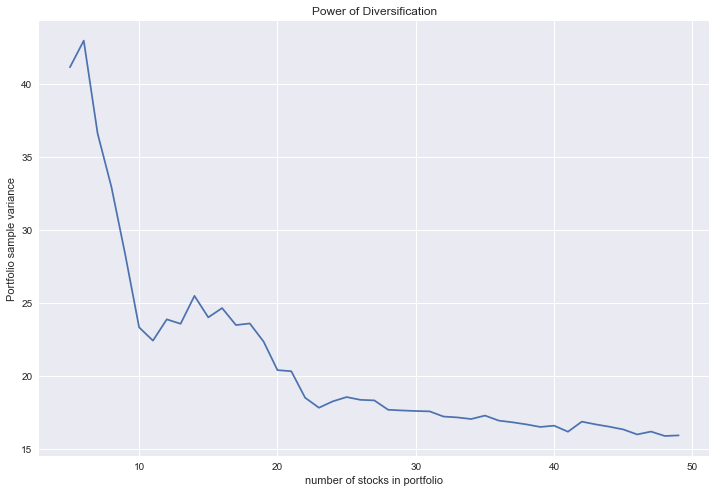

In [22]:
start = 5
end = df.shape[1]

storage1 = []

for i in range(start, end):
    
    x = df.iloc[:,:i]
    
    x_mean = x.mean()
    x_cov = x.cov()
    w = np.asarray([1/i]*i)
    
    pf_return = np.sum(x_mean*w)
    pf_var = np.dot(w, np.dot(x_cov,w))
   
    stats = (pf_return, pf_var)
    storage1.append(stats)

    
storage1 = np.array(storage1)
plt.style.use('seaborn')
plt.figure(figsize=(12,8))
plt.plot(range(start,end), storage1[:,1])
plt.xlabel('number of stocks in portfolio')
plt.ylabel('Portfolio sample variance')
plt.title('Power of Diversification')
plt.show(block=False)

### (b) 
Plot the variance, average variance, and average covariance of the equal-weighted portfolio as a function of the number of stocks.

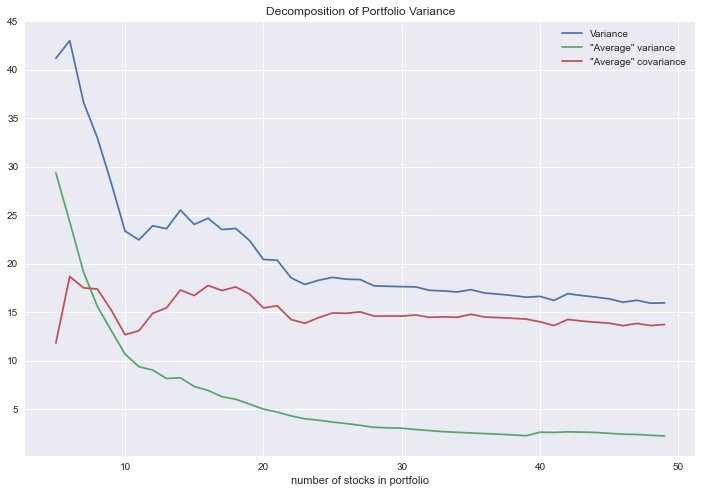

In [23]:
storage2 = []

for i in range(start, end):
    
    x = df.iloc[:,:i]

    x_cov = x.cov()
    x_diag = np.diag(x_cov)
    avg_var = (1/i)*np.mean(x_diag)

    x_offsum = np.sum(np.sum(x_cov)) - np.sum(x_diag)
    avg_covar = (1/(i**2))*x_offsum
   
    stats = (avg_var, avg_covar)
    storage2.append(stats)

    
storage2 = np.array(storage2)
store_all = np.concatenate((storage1, storage2), axis=1)
                           
labels = ['Variance', '"Average" variance', '"Average" covariance']
plt.style.use('seaborn')
plt.figure(figsize=(12,8))
plt.plot(range(start,end), store_all[:,1:4])
plt.xlabel('number of stocks in portfolio')
plt.ylabel('')
plt.title('Decomposition of Portfolio Variance')
plt.legend(labels)
plt.show()

### (C)
- mean variance frontier

In [24]:
# Two risky assets

def get_weights_variance(mu, e1, e2, sig11, sig12, sig22):
    w1 = (mu - e2) / (e1 - e2)
    w2 = 1 - w1
    var = w1**2*sig11**2 + 2*w1*w2*sig12 + w2**2*sig22**2
    std = np.sqrt(var)
    return w1,w2,std,var

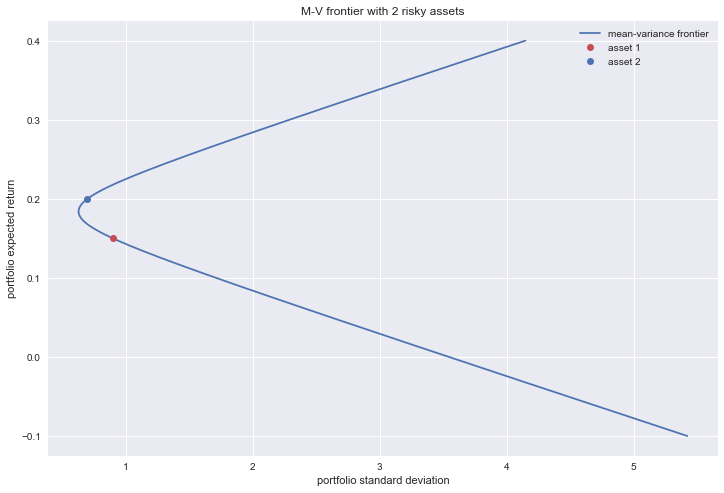

In [25]:
e1 = 0.15
e2 = 0.20
sig11 = 0.9
sig12 = 0.2
sig22 = 0.7

var_list = []
for x in np.linspace(-0.1,0.4,10000) :
    w1,w2,std,var = get_weights_variance(x, e1, e2, sig11, sig12, sig22)
    m = w1*e1 + w2*e2
    var_list.append(std)
    
x = np.linspace(-0.1,0.4,10000)
y = var_list

plt.style.use('seaborn')
plt.figure(figsize=(12,8))
plt.plot(y,x, label = 'mean-variance frontier')
plt.plot(sig11, e1, 'ro', label = 'asset 1')
plt.plot(sig22, e2, 'bo', label = 'asset 2')
plt.title('M-V frontier with 2 risky assets')
plt.xlabel('portfolio standard deviation')
plt.ylabel('portfolio expected return')
plt.legend()
plt.show()

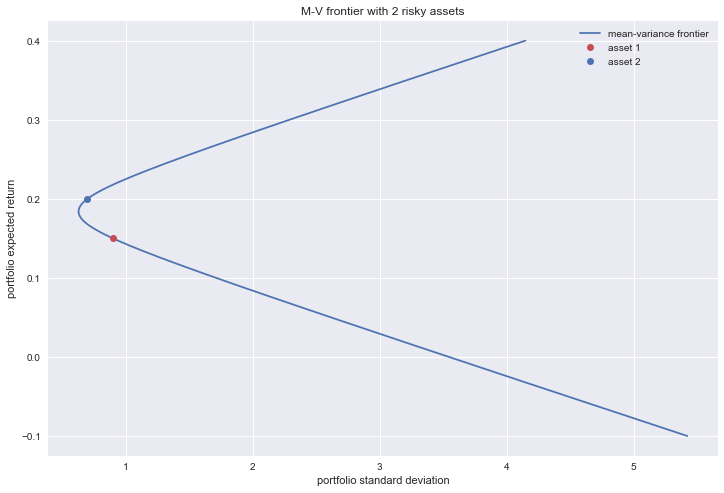

In [26]:
e1 = 0.15
e2 = 0.20
sig11 = 0.9
sig12 = 0.2
sig22 = 0.7

var_list = []
for x in np.linspace(-0.1,0.4,10000) :
    w1,w2,std,var = get_weights_variance(x, e1, e2, sig11, sig12, sig22)
    m = w1*e1 + w2*e2
    var_list.append(std)
    
x = np.linspace(-0.1,0.4,10000)
y = var_list

plt.style.use('seaborn')
plt.figure(figsize=(12,8))
plt.plot(y,x, label = 'mean-variance frontier')
plt.plot(sig11, e1, 'ro', label = 'asset 1')
plt.plot(sig22, e2, 'bo', label = 'asset 2')
plt.title('M-V frontier with 2 risky assets')
plt.xlabel('portfolio standard deviation')
plt.ylabel('portfolio expected return')
plt.legend()
plt.show()

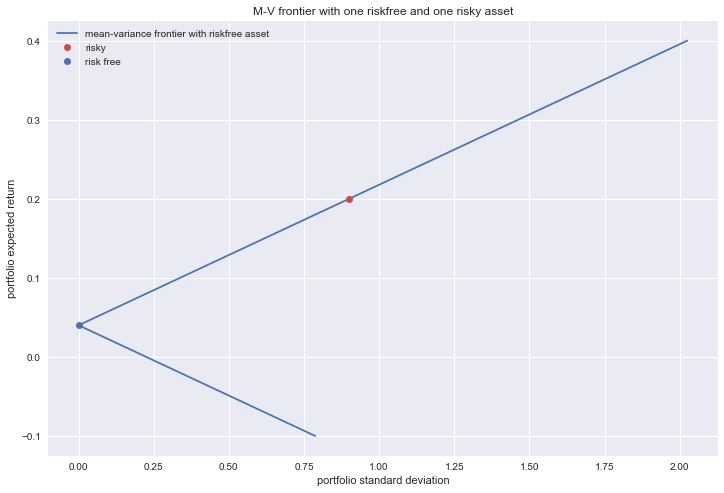

In [27]:
# one risk free, one risky
rf = 0.04
e1 = 0.2
sigma = 0.9

def get_weights_variance_rf(mu, e1, rf, sigma) :
    w1 = (mu - rf) / (e1 - rf)
    w2 = 1 - w1
    var = w1**2*sigma**2
    std = np.sqrt(var)
    return w1,w2,std,var

var_list = []
for x in np.linspace(-0.1,0.4,10000) :
    std = get_weights_variance_rf(x, e1, rf, sigma)[2]
    var_list.append(std)
    
x = np.linspace(-0.1,0.4,10000)
y = var_list

plt.style.use('seaborn')
plt.figure(figsize=(12,8))
plt.plot(y,x, label = 'mean-variance frontier with riskfree asset')
plt.plot(sigma, e1, 'ro', label = 'risky')
plt.plot(0, rf, 'bo', label = 'risk free')
plt.title('M-V frontier with one riskfree and one risky asset')
plt.xlabel('portfolio standard deviation')
plt.ylabel('portfolio expected return')
plt.legend()
plt.show()

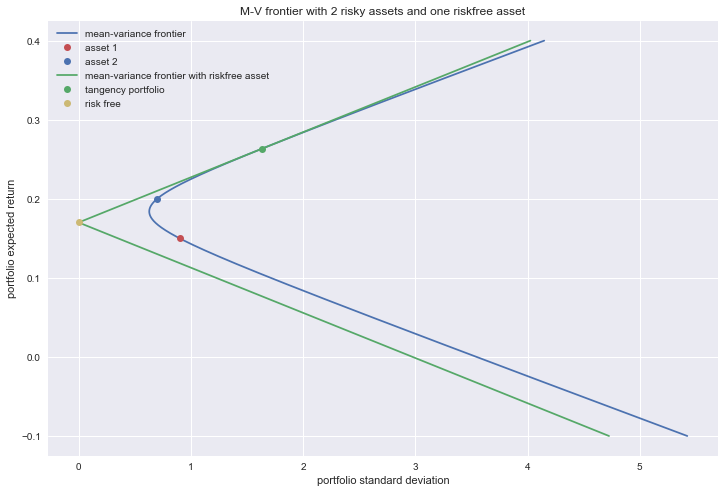

In [28]:
e1 = 0.15
e2 = 0.20
sig11 = 0.9
sig12 = 0.2
sig22 = 0.7
rf = 0.17

def get_weights_variance(mu, e1, e2, sig11, sig12, sig22):
    w1 = (mu - e2) / (e1 - e2)
    w2 = 1 - w1
    var = w1**2*sig11**2 + 2*w1*w2*sig12 + w2**2*sig22**2
    std = np.sqrt(var)
    return w1,w2,std,var

var_list = []
store_m, store_std, s_ratio = 0, 0, 0
for x in np.linspace(-0.1,0.4,10000) :
    w1,w2,std,var = get_weights_variance(x, e1, e2, sig11, sig12, sig22)
    m = w1*e1 + w2*e2
    var_list.append(std)
    if (m-rf)/std > s_ratio :
        store_m = m
        store_std = std
        s_ratio = (m-rf)/std
    
var_list1 = []
for x in np.linspace(-0.1,0.4,10000) :
    std1 = get_weights_variance_rf(x, store_m, rf, store_std)[2]
    var_list1.append(std1)
    
x = np.linspace(-0.1,0.4,10000)
y = var_list
y1 = var_list1

plt.style.use('seaborn')
plt.figure(figsize=(12,8))
plt.plot(y,x, label = 'mean-variance frontier')
plt.plot(sig11, e1, 'ro', label = 'asset 1')
plt.plot(sig22, e2, 'bo', label = 'asset 2')
plt.plot(y1,x, label = 'mean-variance frontier with riskfree asset')
plt.plot(store_std, store_m, 'go', label = 'tangency portfolio')
plt.plot(0, rf, 'yo', label = 'risk free')
plt.title('M-V frontier with 2 risky assets and one riskfree asset')
plt.xlabel('portfolio standard deviation')
plt.ylabel('portfolio expected return')
plt.legend()
plt.show()